##  Problem 8.2: Microtubule catastrophe

Attribution: Xinhong did the coding for this problem, the whole group discuss and give suggestions.

(The Stan codes are shown below for reference, but we always complie the standalone ones in this homework)

In [1]:
import itertools

import numpy as np
import pandas as pd
import scipy.stats as st
import random

import numba

import bebi103


import altair as alt 
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

Usually when start building the prior, we should not look at the data first, but since we are lack of prior knowledge of the microtubule catastrophe, we would like to read in the data first and get a sense of what microtube catastrophe looks like.

In [5]:
# read in the dataset
df = pd.read_csv('./data/gardner_mt_catastrophe_only_tubulin.csv')
df[0:15]

,# Raw data from Gardner,et al.,Cell,147,1092,2011.
0,#,NaN,NaN,NaN,NaN,NaN
1,# Each entry in the respective columns is the ...,in seconds,,NaN,NaN,NaN
2,# between the start of growth of a microtubule...,NaN,NaN,NaN,NaN,NaN
3,#,NaN,NaN,NaN,NaN,NaN
4,# The concentrations of tubulin are given at t...,NaN,NaN,NaN,NaN,NaN
5,# of each column.,NaN,NaN,NaN,NaN,NaN
6,#,NaN,NaN,NaN,NaN,NaN
7,# Kindly provided by Melissa Gardner,University of Minnesota,NaN,NaN,NaN,NaN
8,12 uM,7 uM,9 uM,10 uM,14 uM,NaN
9,25,35,25,50,60,NaN


Seems the information we want is from 10th row, let's re-read the CSV and skip the first 9 rows.

In [6]:
# re-read in the dataset
df = pd.read_csv('./data/gardner_mt_catastrophe_only_tubulin.csv',  skiprows=range(0, 9))
df.columns = df.columns.get_level_values(0)
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35.0,25.0,50.0,60.0
1,40.000,45.0,40.0,60.0,75.0
2,40.000,50.0,40.0,60.0,75.0
3,45.429,50.0,45.0,75.0,85.0
4,50.000,55.0,50.0,75.0,115.0


Let's add one more column 'measurement' for the convenience of plotting.

In [7]:
# add one more column 'point' for the convenience of plotting
df.insert(0, 'measurement', range(0, 0 + len(df)))
df.head()

,measurement,12 uM,7 uM,9 uM,10 uM,14 uM
0,0,25.000,35.0,25.0,50.0,60.0
1,1,40.000,45.0,40.0,60.0,75.0
2,2,40.000,50.0,40.0,60.0,75.0
3,3,45.429,50.0,45.0,75.0,85.0
4,4,50.000,55.0,50.0,75.0,115.0


Let's plot the data for one of the concentration to get a sense.

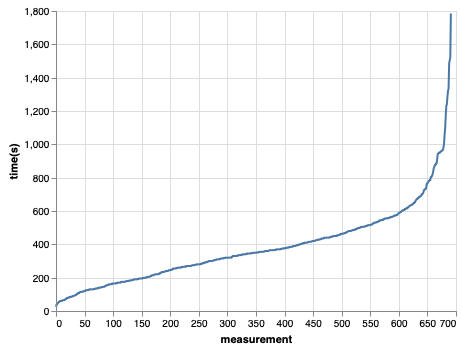

In [8]:
# Plot one of the concentration
alt.Chart(df
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('measurement:Q', title='measurement'),
        y=alt.Y('12 uM:Q', title='time(s)'),
        order='time:Q'
    )

To get a better idea of the distribution, we would like to plor a ECDF for this concentration.

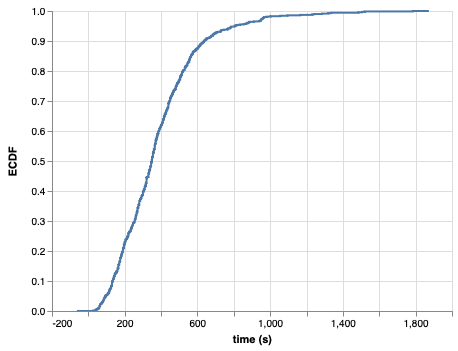

In [22]:
# Plot ECDF of 
altcat.catplot(data = df,
               mark = 'line',
               encoding=dict(x=alt.X('12 uM:Q', title='time (s)')),
               transform = 'ecdf'
              )

After we get a general sense of what microtube catastrophe looks like, let's start the journey for tackling this questions, there are three models provided by the problems:

Model 1: The time to catastrophe is Exponentially distributed.  
Model 2: The time to catastrophe is Gamma distributed.   
Model 3: The time to catastrophe is Weibull distributed.

#### a) Describe the three models in words. Give physical descriptions of the meanings of their parameters. Describe how these models are related to each other. Tutorial 3c will be useful.

#### Model1 (Exponential)
The Probability density function of the time is 
\begin{align}
f(y;\beta) = \beta\, \mathrm{e}^{-\beta y}.
\end{align}  
Alternatively, we could parametrize the Exponential distribution in terms of an average time between arrivals of a Poisson process, $\tau$, as
    \begin{align}
    \\\phantom{blah}
    f(y;\tau) = \frac{1}{\tau}\, \mathrm{e}^{-y/\tau}.
    \\\phantom{blah}
    \end{align}
our likelihood is ,

\begin{align}
f(D\mid \tau, M_1) = \prod_{i\in D} \frac{\mathrm{e}^{-t_i/\tau}}{\tau}.
\end{align}

This model indicates the tubulin catastrophe is a poisson process, it occur with a rate $\lambda$ per unit
time, and there is no "memory" of previous events, that rate is independent of time. The single paramter in this model is the avarage arrival time between arrivals, $\beta$. So the $\beta$ here could represent the time bewteen 2 catastrophes, and if we assume the tubulin growth is linearly, the $\beta$ would also indicate how long the tubulin would grow between 2 catastrophes. 

#### Model2 (Gamma)

The Probability density function of time is

\begin{align}
f(y;\alpha, \beta) = \frac{1}{\Gamma(\alpha)}\,\frac{(\beta y)^\alpha}{y}\,\mathrm{e}^{-\beta y}.
\end{align}

Alternatively, we could parametrize the distribution in terms of an average time between arrivals of a Poisson process, $\tau$, and our likelihood is 

\begin{align}
f(D\mid \tau, a, M_2) = \prod_{i\in D} \frac{\left(t_i/\tau\right)^a}{t_i\Gamma(a)}\,\mathrm{e}^{-t_i/\tau},
\end{align}

This model indicates the amount of time we have to wait for $\alpha$ arrivals of a Poisson process. There are 2 parameters in this model. The number of arrivals, $\alpha$, and the rate of
arrivals, $\beta$. $\alpha$ here could represent how many poisson processes should happen before a catastrophe happen, and we know lots of molecular rearragenment is a poisson process, so biologically, this model indicates a catastrophe would only happen after several certain possion process such as modifications, and $\alpha$ could possibily represent the numbers of modifications it need before a catastrophe. And $\beta$ represent the rate of arrival of those poisson process, so $\tau$ represents the average time between arrivals of a Poisson process

When the $\alpha$ becomes 1, which means it only need one poisson process to happen before a catastrophe, and the waiting time for that would be an exponential distribution, so it becomes Model1(Exponential).

#### Model3 (Weibull)

The Probability density function of time is

\begin{align}
f(y;\alpha, \sigma) = \frac{\alpha}{\sigma}\left(\frac{y}{\sigma}\right)^{\alpha - 1}\,
\mathrm{e}^{-(y/\sigma)^\alpha}.
\end{align}

There are two parameters in this model, the shape parameter $\alpha$, which dictates the shape of the
curve, and the scale parameter $\sigma$, which indictates the rate of arrivals of the event. When the $\alpha$>1, it means the longer we wait the more likely a catastrophe would happen. This model indicates that the longer the tubulin grow, the larger chance it is going into a catastrophe, biologically, it could means the tubulin become more stable when growing longer, maybe exposed more recorgnition site for relevant enzyme. And the value of $\alpha$ represents how fast the chance increase when we wait longer, could represent how fast the increase of exposed recorgnition sites when growing longer. And $\sigma$ indictates the rate of arrivals of that event.

When $\alpha$ is 1, it turns into exponential distribution.

#### b) Perform parameter estimates for the respective models and make model comparisons. Comment on what this means with respect to our understanding of how microtubule catastrophe works.

#### Model1 (Exponential)

\begin{align}
f(y;\beta) = \beta\, \mathrm{e}^{-\beta y}.
\end{align}  

$\beta$ indicates the wait time between catastrophe, so we would speculate it lies in a normal distribution. In summary, our prior is:

$$\beta \sim Norm(250, 80)$$

And the likelihood is 

$$I(t) \sim Exponential(\beta)$$ 


First let's do the prior predictive check:

In [14]:
prior_predictive_model_code_1 = """
data {
  int N;
  real beta_0_phi;
  real beta_0_sigma;
}


generated quantities {
  // Parameters
  real<lower=0> beta;

  // Data
  real ell[N];

  beta = normal_rng(beta_0_phi, beta_0_sigma);

  for (i in 1:N) {
    ell[i] = exponential_rng(1/beta);
  }
}
"""


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2568e487bfff219b8b2462edf63282a NOW.


The Stan code is attached above for reference, but the model is complied from a standalone file.

In [18]:
sm_gen = bebi103.stan.StanModel(file = 'hw82_prior_predictive_model_code_1.Stan')

Using cached StanModel.


Now we have the stan model for the prior predictive check. Let's specify the parameters and pass it to stan.

In [19]:
# Specify the paramters
data = dict(N=len(df),
            beta_0_phi = 250,
            beta_0_sigma = 80)

In [20]:
# Pass the parameters into StanModel
samples_gen = sm_gen.sampling(data=data,
                              algorithm='Fixed_param',
                              warmup=0,
                              chains=1,
                              iter=1000)

Let's do prior predictive check by plotting the prior predictive ECDF from the samples we get from stan.

In [21]:
# Show the prior predictive ECDF
bokeh.io.show(
    bebi103.viz.predictive_ecdf(samples_gen, 
                                'ell', 
                                x_axis_label='time (s)'))

The prior predictive ECDF looks quite reasonable, medium at around 400, most of the data is smaller than around 1000, consistent with the prior knowledge we have about tubulin catastrophe. Let's go ahead doing paramter estimation and posterior predictive check.  
Let's build the stan code for both paramter estimation and posterior predictive check. 

In [23]:
model_code1 = """
data {
  int N;
  real n[N];
}


parameters {
    real<lower=0> b;
}


transformed parameters {
  real beta_ = 1.0 / b;
}


model {
  // Priors
  b ~ normal(250.0, 80.0);

  // Likelihood
  n ~ exponential(beta_);
}


generated quantities {
  real n_ppc[N];
  real log_lik[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = exponential_rng(beta_);
  }
  
  // Compute pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = exponential_lpdf(n[i] | beta_);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [25]:
sm = bebi103.stan.StanModel(file='hw82_model_code1.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93dc45a3fc2f916bed05cef6f8ab878e NOW.


Now, when we draw our samples using Stan, we also get our predictive check samples.

In [26]:
# Load data and make data dictionary
data = {'N': len(df), 'n': df['12 uM'].values}

# Perform sampling
model1_samples = sm.sampling(data=data)

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We should always do diagnostics check whether we make draws.

In [27]:
# Check diagnostics
bebi103.stan.check_all_diagnostics(model1_samples)

n_eff / iter looks reasonable for all parameters.
Rhat for parameter beta_ is nan.
Rhat for parameter log_lik[395] is nan.
Rhat for parameter log_lik[396] is nan.
Rhat for parameter log_lik[397] is nan.
Rhat for parameter log_lik[398] is nan.
Rhat for parameter log_lik[399] is nan.
Rhat for parameter log_lik[400] is nan.
Rhat for parameter log_lik[401] is nan.
Rhat for parameter log_lik[402] is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


2

Although there are some nan value here, it could be the result of using normal distributon in our prior and generate some negative data. But the other stuffs look good, no divergence and no pathological behavior in general. 

let's also plot our samples using the corner plot to estimate our parameters.

In [28]:
# Make a corner plot for paramter estimation
bokeh.io.show(bebi103.viz.corner(model1_samples, 
                                 pars=['b'], 
                                 labels=['β']))

As Justin suggested before, the corner plot is actually the best way to summarize the posterior and visualize how parameter varies. We think it's the best way to present our result of 'parameter estimation'. We could see roughly the $\beta$ has the median at around 380, which indicates the time bewteen 2 catastrophes has a median at around 380s.

Let's also do posterior predictive check on this model by plotting the posterior predictive ECDF.

In [29]:
# posterior predictive check by plotting the predictive ECDF
bokeh.io.show(bebi103.viz.predictive_ecdf(model1_samples, 
                                          name='n_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

It clearly fails the posterior predictive check, indicating the Model1 is far from the real data. It is not a good model at all, and we could stop here for Model1.

#### Model2 (Gamma)

\begin{align}
f(y;\alpha, \beta) = \frac{1}{\Gamma(\alpha)}\,\frac{(\beta y)^\alpha}{y}\,\mathrm{e}^{-\beta y}.
\end{align}

$\alpha$ is the number of poisson process that need to happen before catastrophe, and we know the factors (number of poisson process) that would lead to catstrophe may not be a lot, so let's put it in a normal distribution with a small mean. $\beta$ indicates the time between arrivals of those different poisson processs, so we would speculate it also lies in a normal distribution. In summary, our prior is:

$$\alpha \sim Norm(1, 0.5)$$
$$\beta \sim Norm(250, 80)$$

And the likelihood is 

$$I(t) \sim Gamma(\alpha, \beta)$$ 

Let's do prior predictive check.

In [30]:
prior_predictive_model_code_2 = """
data {
  int N;
  real a_0_phi;
  real a_0_sigma;
  real beta_0_phi;
  real beta_0_sigma;
}


generated quantities {
  // Parameters
  real<lower=0> a;
  real<lower=0> beta;

  // Data
  real ell[N];

  a = normal_rng(a_0_phi, a_0_sigma);
  beta = normal_rng(beta_0_phi, beta_0_sigma);

  for (i in 1:N) {
    ell[i] = gamma_rng(a, 1/beta);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [31]:
sm_gen = bebi103.stan.StanModel(file='hw82_prior_predictive_model_code_2.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f3953f9fbe51ff240738cbd10944874 NOW.


Now we have the stan model for the prior predictive check. Let's specify the parameters and pass it to stan.

In [32]:
# Specify the paramters
data = dict(N=len(df),
            a_0_phi = 1,
            a_0_sigma = 0.5,
            beta_0_phi = 250,
            beta_0_sigma = 80)

# Pass the paramters to StanModel
samples_gen = sm_gen.sampling(data=data,
                              algorithm='Fixed_param',
                              warmup=0,
                              chains=1,
                              iter=1000)

Let's do prior predictive check by plotting the prior predictive ECDF from the samples we get from stan.

In [33]:
# Show the prior predictive ECDF
bokeh.io.show(
    bebi103.viz.predictive_ecdf(samples_gen, 
                                'ell', 
                                x_axis_label='time (s)'))

The prior predictive ECDF looks quite reasonable, medium at around 400, most of the data is smaller than around 1000, consistent with the prior knowledge we have about tubulin catastrophe. Let's go ahead doing paramter estimation and posterior predictive check.  
Let's build the stan code for both paramter estimation and posterior predictive check. 

In [34]:
model_code2 = """
data {
  int N;
  real n[N];
}


parameters {
  real<lower=0> a;
  real<lower=0> b;
}


transformed parameters {
  real beta_ = 1.0 / b;
}


model {
  // Priors
  a ~ normal(1, 0.5);
  b ~ normal(250.0, 80.0);;

  // Likelihood
  n ~ gamma(a, beta_);
}


generated quantities {
  real n_ppc[N];
  real log_lik[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = gamma_rng(a, beta_);
  }
  
  // Compute pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = gamma_lpdf(n[i] | a, beta_);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [35]:
sm = bebi103.stan.StanModel(file='hw82_model_code2.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf4dd3205bd6825487f9e8c465fd3909 NOW.


Now, when we draw our samples using Stan, we also get our predictive check samples.

In [36]:
# Load data and make data dictionary
data = {'N': len(df), 'n': df['12 uM'].values}

# Perform sampling
model2_samples = sm.sampling(data=data)

We should always do diagnostics check whether we make draws.

In [37]:
# Check diagnostics
bebi103.stan.check_all_diagnostics(model2_samples)

n_eff / iter looks reasonable for all parameters.
Rhat for parameter beta_ is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


2

The drawing in general looks fine, no divergence and no pathological behavior. 

let's also plot our samples using the corner plot to estimate our parameters.

In [38]:
# Make a corner plot for paramter estimation
bokeh.io.show(bebi103.viz.corner(model2_samples, 
                                 pars=['a', 'b'],
                                 labels=['α', 'β']))

As we mentioned before, the corner plot is actually the best way to summarize the posterior and visualize how parameter varies. We think it's the best way to present our result of 'parameter estimation'. We could see roughly the $\beta$ has the median at around 140, which indicates the time bewteen 2 poisson process has a median at around 140s. And $\alpha$ center around 2.8, it could indicating there are around 3 molecular arrangements need to happen before a catastrophe.

Let's also do posterior predictive check on this model by plotting the posterior predictive ECDF.

In [39]:
# posterior predictive check by plotting the predictive ECDF
bokeh.io.show(bebi103.viz.predictive_ecdf(model2_samples, 
                                          percentiles=[99, 70, 50, 30],
                                          name='n_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

None of the data points lie outside the 99th percentile, the model passes the posterior predictive check. It is a fairly reasonable model. 

For further model comparison, let's compute the WAIC and LOO of these samples:

In [40]:
waic_results_model2 = bebi103.stan.waic(model2_samples, log_likelihood='log_lik')
loo_results_model2 = bebi103.stan.loo(model2_samples, log_likelihood='log_lik')

print('Model2:')
print(waic_results_model2, end='\n\n')
print(loo_results_model2, end='\n\n')

Model2:
          waic    waic_se    p_waic  warning
0  9279.692012  43.551964  2.037328        0

           loo     loo_se     p_loo  warning
0  9279.692515  43.552077  2.037579        0



Let’s save these data for model2 and move on to model3 now.

#### Model3 (Weibull)

\begin{align}
f(y;\alpha, \sigma) = \frac{\alpha}{\sigma}\left(\frac{y}{\sigma}\right)^{\alpha - 1}\,
\mathrm{e}^{-(y/\sigma)^\alpha}.
\end{align}

There are two parameters in this model, the shape parameter $\alpha$, which dictates the shape of the
curve, and the scale parameter $\sigma$, which indictates the rate of arrivals of the event. When the $\alpha$>1, it means the longer we wait the more likely a catastrophe would happen，which is consistent with our intuition. So let's put the $\alpha$ in (1+ Normal distribution). And $\sigma$ indictates the rate of arrivals of that event, but here for convenient, we could use the $\beta$ (1/$\sigma$) instead, and $\beta$ should lie in a normal distribution.


In summary, our prior is:

$$\alpha \sim 1 + Norm(0, 2)$$
$$\beta \sim Norm(250, 80)$$

And the likelihood is 

$$I(t) \sim Gamma(\alpha, \beta)$$ 

Let's do prior predictive check.

In [41]:
prior_predictive_model_code_3 = """
data {
  int N;
  real a_0_phi;
  real a_0_sigma;
  real beta_0_phi;
  real beta_0_sigma;
}


generated quantities {
  // Parameters
  real a;
  real beta;

  // Data
  real ell[N];

  a = 1+fabs(normal_rng(a_0_phi, a_0_sigma));
  beta = normal_rng(beta_0_phi, beta_0_sigma);

  for (i in 1:N) {
    ell[i] = weibull_rng(a, beta);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [42]:
sm_gen = bebi103.stan.StanModel(file='hw82_prior_predictive_model_code_3.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05226caa6b7607ef7fc7d05561daaa10 NOW.


Now we have the stan model for the prior predictive check. Let's specify the parameters and pass it to stan.

In [43]:
# Specify the parameters 
data = dict(N=len(df),
            a_0_phi = 0,
            a_0_sigma = 2,
            beta_0_phi = 250,
            beta_0_sigma = 80)

# Pass the parameters to StanModel
samples_gen = sm_gen.sampling(data=data,
                              algorithm='Fixed_param',
                              warmup=0,
                              chains=1,
                              iter=1000)

Let's do prior predictive check by plotting the prior predictive ECDF from the samples we get from stan.

In [44]:
# Show the prior predictive ECDF
bokeh.io.show(
    bebi103.viz.predictive_ecdf(samples_gen, 
                                'ell', 
                                x_axis_label='time (s)'))

The prior predictive ECDF looks quite reasonable, medium at around 400, most of the data is smaller than around 1000, consistent with the prior knowledge we have about tubulin catastrophe. Let's go ahead doing paramter estimation and posterior predictive check.  
Let's build the stan code for both paramter estimation and posterior predictive check. 

In [45]:
model_code3 = """
data {
  int N;
  real n[N];
}


parameters {
  real<lower=0> a;
  real<lower=0> beta;
}


model {
  // Priors
  a ~ normal(0, 2);
  beta ~ normal(250, 80);

  // Likelihood
  n ~ weibull(a+1, beta);
}

generated quantities {
  real n_ppc[N];
  real log_lik[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = weibull_rng(a+1 , beta);
  }
  
  // Compute pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = weibull_lpdf(n[i] | a+1 , beta);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [46]:
sm = bebi103.stan.StanModel(file='hw82_model_code3.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1de3108715a51368feb16722d9b4ba64 NOW.


Now, when we draw our samples using Stan, we also get our predictive check samples.

In [47]:
# Load data and make data dictionary
data = {'N': len(df), 'n': df['12 uM'].values}

# Perform sampling
model3_samples = sm.sampling(data=data)

We should always do diagnostics check whether we make draws

In [48]:
# Check diagnostics
bebi103.stan.check_all_diagnostics(model3_samples)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

The drawing in general looks fine, no divergence and no pathological behavior. 

let's also plot our samples using the corner plot to estimate our parameters.

In [49]:
# Make a corner plot for paramter estimation
bokeh.io.show(bebi103.viz.corner(model3_samples, 
                                 pars=['a', 'beta'],
                                 labels=['α-1', 'β']))

As we mentioned before, the corner plot is actually the best way to summarize the posterior and visualize how parameter varies. We think it's the best way to present our result of 'parameter estimation'. We could see roughly the ($\alpha$-1) has the median at around 0.75, which indicates the $\alpha$ has a median at around 1.75. suggestingthe increase of the rate of catastrophe when it grows longer. And $\beta$ center around 425.

Let's also do posterior predictive check on this model by plotting the posterior predictive ECDF.

In [50]:
# posterior predictive check by plotting the predictive ECDF
bokeh.io.show(bebi103.viz.predictive_ecdf(model3_samples, 
                                          percentiles=[99, 70, 50, 30],
                                          name='n_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

Most of the data points lie inside the 99th percentile, the model passes the posterior predictive check. It is a fairly reasonable model. 

For further model comparison, let's compute the WAIC and LOO of these samples:

In [51]:
waic_results_model3 = bebi103.stan.waic(model3_samples, log_likelihood='log_lik')
loo_results_model3 = bebi103.stan.loo(model3_samples, log_likelihood='log_lik')

print('Model3:')
print(waic_results_model3, end='\n\n')
print(loo_results_model3, end='\n\n')

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:871: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


Model3:
          waic    waic_se    p_waic  warning
0  9314.114082  48.562665  3.003583        1

           loo     loo_se     p_loo  warning
0  9314.111294  48.561678  3.002189        0



Since the Model2:Gamma and Model3:Weibull all seems fairy reasonable, and Model1:Expoenential didn't pass the posterior check.  
let's go ahead and do model comparison between Model2(Gamma) and Model3(weibull). 

We already caculate the WAIC and LOO for samples generated from those 2 models, let's print them side by side for comparison.

In [52]:
print('Model2:Gamma')
print(waic_results_model2, end='\n\n')
print(loo_results_model2, end='\n\n')
print('Model3:Weibull')
print(waic_results_model3, end='\n\n')
print(loo_results_model3, end='\n\n')

Model2:Gamma
          waic    waic_se    p_waic  warning
0  9279.692012  43.551964  2.037328        0

           loo     loo_se     p_loo  warning
0  9279.692515  43.552077  2.037579        0

Model3:Weibull
          waic    waic_se    p_waic  warning
0  9314.114082  48.562665  3.003583        1

           loo     loo_se     p_loo  warning
0  9314.111294  48.561678  3.002189        0



We know that the smaller WAIC or LOO is, the bigger the epld is, indicating a smaller Kullback-Leibler divergence (a better model).  
So in general, the smaller WAIC or LOO is, the closer the model is to the true generative model.  
Using this standard, we could easily tell that Model2(Gamma Distribution) is a better model.  

We could also directly compute the Akaike weight to compare the model.

In [53]:
# Compute the Akaike weigh from values of LOO
d_loo = (loo_results_model2['loo'] - loo_results_model3['loo'])[0]
w_model3 = np.exp(d_loo/2) / (1 + np.exp(d_loo/2))
w_model2 = 1 - w_model3

print('Model2(Gamma) weight:', w_model2)
print('Model3(Weibull) weight:', w_model3)

Model2(Gamma) weight: 0.9999999664218147
Model3(Weibull) weight: 3.357818539815303e-08


We could clearly see that Model2(Gamma) is far more predictive than Model3(Weibull).  

In general, Model1(Exponential) is very bad model for the catastrophe time. And Model2(Gamma) is a better model than Model3(Weibull).   
The catastrophe time is most likely gamma distributed.

#### c) Using whichever model you favor based on your work in part (b), obtain parameter estimates for the other tubulin concentrations. Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurrence of catastrophe by looking at the values of the parameters versus tubulin concentration?

According to the analysis above, we think the model2(Gamma) is the best. Let's recall Model2:  
our prior is:

$$\alpha \sim Norm(1, 0.5)$$
$$\beta \sim Norm(250, 80)$$

And the likelihood is 

$$I(t) \sim Gamma(\alpha, \beta)$$  

We already build the Stan code for both paramter estimation and posterior predictive check. 

In [54]:
model_code2 = """
data {
  int N;
  real n[N];
}


parameters {
  real<lower=0> a;
  real<lower=0> b;
}


transformed parameters {
  real beta_ = 1.0 / b;
}


model {
  // Priors
  a ~ normal(1, 0.5);
  b ~ normal(250.0, 80.0);;

  // Likelihood
  n ~ gamma(a, beta_);
}


generated quantities {
  real n_ppc[N];
  real log_lik[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = gamma_rng(a, beta_);
  }
  
  // Compute pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = gamma_lpdf(n[i] | a, beta_);
  }
}
"""

The Stan code is attached above for reference, but the model is complied from a standalone file.

In [55]:
sm = bebi103.stan.StanModel(file= 'hw82_model_code2.Stan')

Using cached StanModel.


Let's load in the data for different concentration. We have concentration for 7,9,10,12,14 uM.

In [56]:
# Slice out the data for each concentration
df_7 = df.loc[df['7 uM']>0]
df_9 = df.loc[df['9 uM']>0]
df_10 = df.loc[df['10 uM']>0]
df_12 = df.loc[df['12 uM']>0]
df_14 = df.loc[df['14 uM']>0]

# Load data and make data dictionary
data_7 = {'N': len(df_7['7 uM']), 'n': df_7['7 uM'].values}
data_9 = {'N': len(df_9['9 uM']), 'n': df_9['9 uM'].values}
data_10 = {'N': len(df_10['10 uM']), 'n': df_10['10 uM'].values}
data_12 = {'N': len(df_12['12 uM']), 'n': df_12['12 uM'].values}
data_14 = {'N': len(df_14['14 uM']), 'n': df_14['14 uM'].values}

# Perform sampling
model2_samples_7 = sm.sampling(data=data_7)
model2_samples_9 = sm.sampling(data=data_9)
model2_samples_10 = sm.sampling(data=data_10)
model2_samples_12 = sm.sampling(data=data_12)
model2_samples_14 = sm.sampling(data=data_14)

We should always do diagnostics check whether we make draws

In [57]:
# Check diagnostics
print('model2_samples_7:')
bebi103.stan.check_all_diagnostics(model2_samples_7)
print('model2_samples_9:')
bebi103.stan.check_all_diagnostics(model2_samples_9)
print('model2_samples_10:')
bebi103.stan.check_all_diagnostics(model2_samples_10)
print('model2_samples_12:')
bebi103.stan.check_all_diagnostics(model2_samples_12)
print('model2_samples_14:')
bebi103.stan.check_all_diagnostics(model2_samples_14)

model2_samples_7:
n_eff / iter looks reasonable for all parameters.
Rhat for parameter beta_ is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.
model2_samples_9:
n_eff / iter looks reasonable for all parameters.
Rhat for parameter beta_ is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.
model2_samples_10:
n_eff / iter looks reasonable for all parameters.
Rhat for parameter beta_ is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathologica

2

All of the draw seems pretty OK. Let's make the corner plot for paramter estimation of each concentration.

In [61]:
# Make a corner plot for paramter estimation
p7 = bebi103.viz.corner(model2_samples_7, 
                        pars=['a', 'b'],
                        labels=['7uM_α', '7uM_β'])
p9 = bebi103.viz.corner(model2_samples_9, 
                        pars=['a', 'b'],
                        labels=['9uM_α', '9uM_β'])
p10 = bebi103.viz.corner(model2_samples_10, 
                        pars=['a', 'b'],
                        labels=['10uM_α', '10uM_β'])
p12 = bebi103.viz.corner(model2_samples_12, 
                        pars=['a', 'b'],
                        labels=['12uM_α', '12uM_β'])
p14 = bebi103.viz.corner(model2_samples_14, 
                        pars=['a', 'b'],
                        labels=['14uM_α', '14uM_β'])

# Display plots
bokeh.io.show(bokeh.layouts.gridplot([p7, p9, p10, p12, p14], ncols=2))

We could see $\alpha$ and $\beta$ show a trend of increasing along with the increasing of the concentration. Let's recall what $\alpha$ and $\beta$ means:  
$\alpha$ is the number of poisson process that need to happen before catastrophe, $\beta$ indicates the time between arrivals of those different poisson processs, the larger $\alpha$ and $\beta$ suggest the catastrophe is 'harder' to happen.  

In general, with higher tubulin concentration, the catastrophe is harder to happen, and the time between the growth and catastrophe is longer. This is actually pretty consistent with the biology of microtubules, because microtubules polymerize faster with higher tubulin cocncentration, when it polymerizes faster, it is harder to go into catastrophe.

In [62]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [63]:
%watermark -v -p bebi103,itertools,numpy,pandas,random,numba,altair,scipy,bokeh,jupyterlab

CPython 3.6.6
IPython 7.0.1

bebi103 0.0.38
itertools n
numpy 1.15.2
pandas 0.23.4
random n
numba 0.40.0
altair 2.2.2
scipy 1.1.0
bokeh 0.13.0
jupyterlab 0.35.0
